## Social Welfare

$s.t. \int T(n)g(n)dn=0$   但是$T(n)$一直大于零，$g(n)$大于等于零，所以这个条件不能成立

## 只考虑Value Function最大化

In [2]:
import numpy as np

kmin=0.9
kmax=0.98
pmin=0.4
pmax=0.6
kk=np.linspace(kmin,kmax,10)#行向量
pp=np.linspace(pmin,pmax,10)
kk=kk.reshape((1,10))
pp=pp.reshape((1,10))
#print(k)
ones=np.ones((10,1))
#print(ones)
kk=np.dot(ones,kk)
pp=np.dot(ones,pp)
# print(k)
kk=np.transpose(kk)
kk=kk.reshape((100,1))
pp=pp.reshape((100,1))
# print(k)
Parameter=np.hstack((kk,pp))
# print(Parameter)

# for i in range(0,100,):
#     k=Parameter[i,0]
#     p=Parameter[i,1]
SocialWelfare=np.zeros((100,1))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy


for i in range(0,1,1):
    k=Parameter[i,0];
    p=Parameter[i,1];
    gamma=0.9;
    epsilon=-0.35;

    rho=0.9;
    C=50;
    # k=0.6;
    # p=0.5;

    a=0.8;
    eta=0.6;
    xmean=a/eta;
    sigma=0.8;
    sd=sigma**2/2/eta
    xmin=xmean-2*sd
    xmax=xmean+2*sd

    I=1000;
    hmin=0.01;
    hmax=100;
    h=np.linspace(hmin,hmax,I);   #列向量  
                                  #linspace(start,stop,num)生成array对象,num是点的数量，包括两端
    h=h.reshape(I,1);
    #print(h);
    dh=(hmax-hmin)/(I-1);

    J=7;
    x=np.linspace(xmin,xmax,J);    # 行向量
    x=x.reshape(1,J);    #此时x的输出结果为[[2  6  5  4]]，可以用x[0][1]来调取
    dx=(xmax-xmin)/(J-1);
    dx2=dx**2;

    hh=np.dot(h,np.ones((1,J)));
    xx=np.dot(np.ones((I,1)),x);

    mu=a-x*eta;      
    s2=0.5*sigma**2;

    Vhf = np.zeros((I,J));
    Vhb = np.zeros((I,J));
    Vxf = np.zeros((I,J));
    Vxb = np.zeros((I,J));
    Vxx = np.zeros((I,J));
    n = np.zeros((I,J));

    chi =  - np.minimum(mu,0)/dx + s2/dx2;              
    yy =  np.minimum(mu,0)/dx - np.maximum(mu,0)/dx - s2*2/dx2;
    zeta = np.maximum(mu,0)/dx + s2/dx2;

    maxit=100;
    crit=10**(-6);
    Delta=1000;

    updiag=np.zeros((I,1));
    for j in range(0,J,1):
        gg=np.tile(zeta[0][j],(I,1));
        updiag=np.vstack([updiag,gg]);

    centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
    for j in range(1,J-1,1):
        gg=np.tile(yy[0][j],(I,1));
        centdiag=np.vstack([centdiag,gg]);
    gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
    centdiag=np.vstack([centdiag,gg])

    lowdiag=np.tile(chi[0][1],(I,1));
    for j in range(2,J,1):
        gg=np.tile(chi[0][j],(I,1));
        lowdiag=np.vstack([lowdiag,gg]);

    centdiag=np.transpose(centdiag);
    Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
    lowdiag=np.transpose(lowdiag);
    Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
    updiag=np.transpose(updiag);
    Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
    Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

    v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
    v=v0;

    maxit=30;
    distm=np.zeros(maxit);
    for m in range(0,maxit,1):   
        V=copy.deepcopy(v);
        Vhf=np.zeros((I,J));
        Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
        Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;

        Vhb=np.zeros((I,J));
        Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
        Vhb[0,:]=(V[1,:]-V[0,:])/dh;

        I_concave=(Vhb>Vhf)+0;

        nf=((1-k)/C*Vhf)**epsilon;
        hf=(1-k)*nf-p*hh;

        nb=((1-k)/C*Vhb)**epsilon;
        hb=(1-k)*nb-p*hh;

        n0=p/(1-k)*hh;
        Vh0=C/(1-k)*n0**(1/epsilon);

        If=(hf>0)+0;
        Ib=(hb<0)+0;

        I0=(1-If-Ib);

        Vh_Upwind=Vhf*If+Vhb*Ib+Vh0*I0;

        n=((1-k)/C*Vh_Upwind)**epsilon;
        u=xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);

    #     where_are_nan = np.isnan(hb)
    #     hb[where_are_nan] = 0
    #     where_are_nan = np.isnan(hf)
    #     hf[where_are_nan] = 0

        X=-np.minimum(hb,0)/dh;
        Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh;
        Z=np.maximum(hf,0)/dh;

        updiag=0;
        for j in range(0,J,1):
            pp=Z[0:I-1,j];
            pp=pp.reshape(I-1,1)
            gg=np.vstack([pp,0]);
            updiag=np.vstack([updiag,gg]);

        Y=np.transpose(Y);
        centdiag=Y.reshape(I*J,1);   #按行来reshape    python中的reshape是按行的，但此处我需要按列来，所以转置

        lowdiag=X[1:I,0];
        lowdiag=lowdiag.reshape(I-1,1);
        for j in range(1,J,1):
            pp=X[1:I,j];
            pp=pp.reshape(I-1,1);
            gg=np.vstack([0,pp]);
            lowdiag=np.vstack([lowdiag,gg]);

        centdiag=np.transpose(centdiag);
        AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();

        lowdiag=np.vstack([lowdiag,0]);
        lowdiag=np.transpose(lowdiag);
        AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();

        updiag=np.vstack([updiag,0]);
        updiag=np.transpose(updiag);
        AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();

        AA=AA_centdiag+AA_lowdiag+AA_updiag;

        A=AA+Bswitch;

        if np.max(abs(np.sum(A,axis=1)))>10**(-9):   #这个最大值不太一样    
            print("Improper Transition Matrix")
            break;

        B=(1/Delta+rho)*identity(I*J).toarray()-A;
        invB=np.linalg.inv(B);

        u=np.transpose(u);
        u_stacked=copy.deepcopy(u.reshape(I*J,1));
        V=np.transpose(V);
        V_stacked=copy.deepcopy(V.reshape(I*J,1));


        b=u_stacked+V_stacked/Delta;

        invBcopy=copy.deepcopy(invB);
        bcopy=np.tile(b,(1,I*J))

#         for j in range(0,I*J,1):
#             for i in range(0,I*J,1):
#                 if (np.isnan(bcopy[i,j])==1)|(bcopy[i,j]==np.inf):
#                     if invBcopy[j,i]==0:
#                         bcopy[i,j]=0;
#         V_stacked2=np.zeros((I*J,1))
#         for j in range(0,I*J,1):
#             V_stacked2[j,0]=np.dot(invBcopy[j,:],bcopy[:,j])
        V_stacked2=np.dot(invBcopy,b)

        V=copy.deepcopy(V_stacked2.reshape(J,I));
        V=np.transpose(V);  #matlab是按列来进行reshape，python按行来reshape

        Vchange=V-v;

        v=copy.deepcopy(V);

        Vchangecopy=copy.deepcopy(Vchange)
    #     where_are_nan = np.isnan(Vchangecopy)
    #     where_are_inf = np.isinf(Vchangecopy)
    #     Vchangecopy[where_are_nan] = 0
    #     Vchangecopy[where_are_inf] = 0

        distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
        print(distm[m]);
        print(m);
        if distm[m]<crit:
            print("Value Function Converged, Iteration =");
            print(m);
            print(distm[m]);
            break;
            
    AT=np.transpose(A)
    b5=np.zeros((I*J,1))
    i_fix=5
    b5[i_fix-1,0]=0.1
    row=np.hstack([np.zeros(i_fix-1),1,np.zeros(I*J-i_fix)])
    AT[i_fix-1,:]=row
    invAT=np.linalg.inv(AT);
    gg=np.dot(invAT,b5);

    g_sum=np.dot(np.transpose(gg),np.ones((I*J,1)))*dh*dx

    gg=gg/g_sum
    # g=np.transpose(gg).reshape(I,J)
    ggcopy=copy.deepcopy(gg)
    # ggcopy=np.transpose(ggcopy)
    g=ggcopy.reshape(J,I)
    g=np.transpose(g)
    
    
#     T=k*n+p*hh
    
#     Tg=T*g
#     TFW1=np.dot(np.ones((1,I)),Tg)
#     TotalFirmWelfare=np.dot(TFW1,np.ones((J,1)))
#     print('k=',k,'p=',p,'FirmWelfare=',TotalFirmWelfare)
#     FirmWelfare[i,0]=TotalFirmWelfare
    Vg=V*g
    TSW1=np.dot(np.ones((1,I)),Vg)
    TotalSocialWelfare=np.dot(TSW1,np.ones((J,1)))
    print('次数=',i,'k=',k,'p=',p,'TotalSocialWelfare=',TotalSocialWelfare)
    
    SocialWelfare[i,0]=TotalSocialWelfare
    


11.365096106576726
0
0.6971526132678676
1
0.04238883796363524
2
0.0003367256296051835
3
1.0631226921020698e-07
4
Value Function Converged, Iteration =
4
1.0631226921020698e-07
次数= 0 k= 0.9 p= 0.4 TotalSocialWelfare= [[474.42066416]]


## 考虑V-T的最大化

同时得到3个结果

In [1]:
import numpy as np

kmin=0.9
kmax=0.98
pmin=0.4
pmax=0.6
kk=np.linspace(kmin,kmax,10)#行向量
pp=np.linspace(pmin,pmax,10)
kk=kk.reshape((1,10))
pp=pp.reshape((1,10))
#print(k)
ones=np.ones((10,1))
#print(ones)
kk=np.dot(ones,kk)
pp=np.dot(ones,pp)
# print(k)
kk=np.transpose(kk)
kk=kk.reshape((100,1))
pp=pp.reshape((100,1))
# print(k)
Parameter=np.hstack((kk,pp))
# print(Parameter)

# for i in range(0,100,):
#     k=Parameter[i,0]
#     p=Parameter[i,1]
Welfare=np.zeros((100,1))
FirmWelfare=np.zeros((100,1))
SocialWelfare=np.zeros((100,1))

In [2]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy


for i in range(0,100,1):
    k=Parameter[i,0];
    p=Parameter[i,1];
    gamma=0.9;
    epsilon=-0.35;

    rho=0.9;
    C=50;
    # k=0.6;
    # p=0.5;

    a=0.8;
    eta=0.6;
    xmean=a/eta;
    sigma=0.8;
    sd=sigma**2/2/eta
    xmin=xmean-2*sd
    xmax=xmean+2*sd

    I=1000;
    hmin=0.01;
    hmax=100;
    h=np.linspace(hmin,hmax,I);   #列向量  
                                  #linspace(start,stop,num)生成array对象,num是点的数量，包括两端
    h=h.reshape(I,1);
    #print(h);
    dh=(hmax-hmin)/(I-1);

    J=7;
    x=np.linspace(xmin,xmax,J);    # 行向量
    x=x.reshape(1,J);    #此时x的输出结果为[[2  6  5  4]]，可以用x[0][1]来调取
    dx=(xmax-xmin)/(J-1);
    dx2=dx**2;

    hh=np.dot(h,np.ones((1,J)));
    xx=np.dot(np.ones((I,1)),x);

    mu=a-x*eta;      
    s2=0.5*sigma**2;

    Vhf = np.zeros((I,J));
    Vhb = np.zeros((I,J));
    Vxf = np.zeros((I,J));
    Vxb = np.zeros((I,J));
    Vxx = np.zeros((I,J));
    n = np.zeros((I,J));

    chi =  - np.minimum(mu,0)/dx + s2/dx2;              
    yy =  np.minimum(mu,0)/dx - np.maximum(mu,0)/dx - s2*2/dx2;
    zeta = np.maximum(mu,0)/dx + s2/dx2;

    maxit=100;
    crit=10**(-6);
    Delta=1000;

    updiag=np.zeros((I,1));
    for j in range(0,J,1):
        gg=np.tile(zeta[0][j],(I,1));
        updiag=np.vstack([updiag,gg]);

    centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
    for j in range(1,J-1,1):
        gg=np.tile(yy[0][j],(I,1));
        centdiag=np.vstack([centdiag,gg]);
    gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
    centdiag=np.vstack([centdiag,gg])

    lowdiag=np.tile(chi[0][1],(I,1));
    for j in range(2,J,1):
        gg=np.tile(chi[0][j],(I,1));
        lowdiag=np.vstack([lowdiag,gg]);

    centdiag=np.transpose(centdiag);
    Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
    lowdiag=np.transpose(lowdiag);
    Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
    updiag=np.transpose(updiag);
    Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
    Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

    v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
    v=v0;

    maxit=30;
    distm=np.zeros(maxit);
    for m in range(0,maxit,1):   
        V=copy.deepcopy(v);
        Vhf=np.zeros((I,J));
        Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
        Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;

        Vhb=np.zeros((I,J));
        Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
        Vhb[0,:]=(V[1,:]-V[0,:])/dh;

        I_concave=(Vhb>Vhf)+0;

        nf=((1-k)/C*Vhf)**epsilon;
        hf=(1-k)*nf-p*hh;

        nb=((1-k)/C*Vhb)**epsilon;
        hb=(1-k)*nb-p*hh;

        n0=p/(1-k)*hh;
        Vh0=C/(1-k)*n0**(1/epsilon);

        If=(hf>0)+0;
        Ib=(hb<0)+0;

        I0=(1-If-Ib);

        Vh_Upwind=Vhf*If+Vhb*Ib+Vh0*I0;

        n=((1-k)/C*Vh_Upwind)**epsilon;
        u=xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);

    #     where_are_nan = np.isnan(hb)
    #     hb[where_are_nan] = 0
    #     where_are_nan = np.isnan(hf)
    #     hf[where_are_nan] = 0

        X=-np.minimum(hb,0)/dh;
        Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh;
        Z=np.maximum(hf,0)/dh;

        updiag=0;
        for j in range(0,J,1):
            pp=Z[0:I-1,j];
            pp=pp.reshape(I-1,1)
            gg=np.vstack([pp,0]);
            updiag=np.vstack([updiag,gg]);

        Y=np.transpose(Y);
        centdiag=Y.reshape(I*J,1);   #按行来reshape    python中的reshape是按行的，但此处我需要按列来，所以转置

        lowdiag=X[1:I,0];
        lowdiag=lowdiag.reshape(I-1,1);
        for j in range(1,J,1):
            pp=X[1:I,j];
            pp=pp.reshape(I-1,1);
            gg=np.vstack([0,pp]);
            lowdiag=np.vstack([lowdiag,gg]);

        centdiag=np.transpose(centdiag);
        AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();

        lowdiag=np.vstack([lowdiag,0]);
        lowdiag=np.transpose(lowdiag);
        AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();

        updiag=np.vstack([updiag,0]);
        updiag=np.transpose(updiag);
        AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();

        AA=AA_centdiag+AA_lowdiag+AA_updiag;

        A=AA+Bswitch;

        if np.max(abs(np.sum(A,axis=1)))>10**(-9):   #这个最大值不太一样    
            print("Improper Transition Matrix")
            break;

        B=(1/Delta+rho)*identity(I*J).toarray()-A;
        invB=np.linalg.inv(B);

        u=np.transpose(u);
        u_stacked=copy.deepcopy(u.reshape(I*J,1));
        V=np.transpose(V);
        V_stacked=copy.deepcopy(V.reshape(I*J,1));


        b=u_stacked+V_stacked/Delta;

        invBcopy=copy.deepcopy(invB);
        bcopy=np.tile(b,(1,I*J))

#         for j in range(0,I*J,1):
#             for i in range(0,I*J,1):
#                 if (np.isnan(bcopy[i,j])==1)|(bcopy[i,j]==np.inf):
#                     if invBcopy[j,i]==0:
#                         bcopy[i,j]=0;
#         V_stacked2=np.zeros((I*J,1))
#         for j in range(0,I*J,1):
#             V_stacked2[j,0]=np.dot(invBcopy[j,:],bcopy[:,j])
        V_stacked2=np.dot(invBcopy,b)

        V=copy.deepcopy(V_stacked2.reshape(J,I));
        V=np.transpose(V);  #matlab是按列来进行reshape，python按行来reshape

        Vchange=V-v;

        v=copy.deepcopy(V);

        Vchangecopy=copy.deepcopy(Vchange)
    #     where_are_nan = np.isnan(Vchangecopy)
    #     where_are_inf = np.isinf(Vchangecopy)
    #     Vchangecopy[where_are_nan] = 0
    #     Vchangecopy[where_are_inf] = 0

        distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
        print(distm[m]);
        print(m);
        if distm[m]<crit:
            print("Value Function Converged, Iteration =");
            print(m);
            print(distm[m]);
            break;
            
    AT=np.transpose(A)
    b5=np.zeros((I*J,1))
    i_fix=5
    b5[i_fix-1,0]=0.1
    row=np.hstack([np.zeros(i_fix-1),1,np.zeros(I*J-i_fix)])
    AT[i_fix-1,:]=row
    invAT=np.linalg.inv(AT);
    gg=np.dot(invAT,b5);

    g_sum=np.dot(np.transpose(gg),np.ones((I*J,1)))*dh*dx

    gg=gg/g_sum
    # g=np.transpose(gg).reshape(I,J)
    ggcopy=copy.deepcopy(gg)
    # ggcopy=np.transpose(ggcopy)
    g=ggcopy.reshape(J,I)
    g=np.transpose(g)
    
    
    T=k*n+p*hh
    
    Tg=T*g
    TFW1=np.dot(np.ones((1,I)),Tg)
    TotalFirmWelfare=np.dot(TFW1,np.ones((J,1)))
    print('k=',k,'p=',p,'FirmWelfare=',TotalFirmWelfare)
    FirmWelfare[i,0]=TotalFirmWelfare
    
    Vg=V*g
    TSW1=np.dot(np.ones((1,I)),Vg)
    TotalSocialWelfare=np.dot(TSW1,np.ones((J,1)))
    
    D=TotalSocialWelfare-TotalFirmWelfare
    
    print('次数=',i,'k=',k,'p=',p,'TSW=',TotalSocialWelfare,'TFW=',TotalFirmWelfare,'作差=',D)
    
    Welfare[i,0]=D
    SocialWelfare[i,0]=TotalSocialWelfare
    FirmWelfare[i,0]=TotalFirmWelfare


11.365096106576726
0
0.6971526132678676
1
0.04238883796363524
2
0.0003367256296051835
3
1.0631226921020698e-07
4
Value Function Converged, Iteration =
4
1.0631226921020698e-07
k= 0.9 p= 0.4 FirmWelfare= [[358.76123239]]
次数= 0 k= 0.9 p= 0.4 TSW= [[474.42066416]] TFW= [[358.76123239]] 作差= [[115.65943177]]
11.42466357038839
0
0.7010156894003714
1
0.04286496056334954
2
0.00035078445926473023
3
1.1466694438411196e-07
4
Value Function Converged, Iteration =
4
1.1466694438411196e-07
k= 0.9 p= 0.4222222222222222 FirmWelfare= [[353.05472496]]
次数= 1 k= 0.9 p= 0.4222222222222222 TSW= [[471.3569765]] TFW= [[353.05472496]] 作差= [[118.30225153]]
11.483884167602522
0
0.7048866254185171
1
0.04334158037810454
2
0.00036531591462996005
3
1.236981663765846e-07
4
Value Function Converged, Iteration =
4
1.236981663765846e-07
k= 0.9 p= 0.4444444444444445 FirmWelfare= [[347.96978163]]
次数= 2 k= 0.9 p= 0.4444444444444445 TSW= [[468.49945056]] TFW= [[347.96978163]] 作差= [[120.52966893]]
11.542757877422641
0
0.7087

11.623602342071113
0
0.6284602971215811
1
0.02769682914966154
2
0.00011866703495222453
3
2.642246421658001e-08
4
Value Function Converged, Iteration =
4
2.642246421658001e-08
k= 0.9177777777777778 p= 0.4888888888888889 FirmWelfare= [[342.10082956]]
次数= 24 k= 0.9177777777777778 p= 0.4888888888888889 TSW= [[454.71847788]] TFW= [[342.10082956]] 作差= [[112.61764831]]
11.682101956203852
0
0.6321671262894668
1
0.02800303307485663
2
0.00012295696586583915
3
2.74368652242174e-08
4
Value Function Converged, Iteration =
4
2.74368652242174e-08
k= 0.9177777777777778 p= 0.5111111111111111 FirmWelfare= [[338.01490859]]
次数= 25 k= 0.9177777777777778 p= 0.5111111111111111 TSW= [[452.36223795]] TFW= [[338.01490859]] 作差= [[114.34732937]]
11.740261252813983
0
0.6358727196962946
1
0.028311541055771272
2
0.00012750177821096997
3
2.8700984699980836e-08
4
Value Function Converged, Iteration =
4
2.8700984699980836e-08
k= 0.9177777777777778 p= 0.5333333333333333 FirmWelfare= [[334.20824614]]
次数= 26 k= 0.91777777

11.823494011556004
0
0.5389040905986313
1
0.01601853531713715
2
3.3032901757934496e-05
3
8.177934773812012e-09
4
Value Function Converged, Iteration =
4
8.177934773812012e-09
k= 0.9355555555555556 p= 0.5555555555555556 FirmWelfare= [[334.99837048]]
次数= 47 k= 0.9355555555555556 p= 0.5555555555555556 TSW= [[437.76347141]] TFW= [[334.99837048]] 作差= [[102.76510093]]
11.881354220982242
0
0.5423669245177152
1
0.016195033127406333
2
3.401249321299815e-05
3
8.397140760507682e-09
4
Value Function Converged, Iteration =
4
8.397140760507682e-09
k= 0.9355555555555556 p= 0.5777777777777777 FirmWelfare= [[331.2686445]]
次数= 48 k= 0.9355555555555556 p= 0.5777777777777777 TSW= [[435.75774346]] TFW= [[331.2686445]] 作差= [[104.48909895]]
11.938882182089479
0
0.5458194426634506
1
0.01636353710362215
2
3.500660729827132e-05
3
8.519467797896141e-09
4
Value Function Converged, Iteration =
4
8.519467797896141e-09
k= 0.9355555555555556 p= 0.6 FirmWelfare= [[328.82577561]]
次数= 49 k= 0.9355555555555556 p= 0.6 TSW

11.448877937841573
0
0.333715021508862
1
0.003997687278499029
2
2.515995653595837e-06
3
1.0028600172518054e-09
4
Value Function Converged, Iteration =
4
1.0028600172518054e-09
k= 0.9622222222222222 p= 0.4 FirmWelfare= [[377.1850769]]
次数= 70 k= 0.9622222222222222 p= 0.4 TSW= [[432.50954736]] TFW= [[377.1850769]] 作差= [[55.32447046]]
11.50965259726378
0
0.33636494359918245
1
0.004053622046939154
2
2.5722320629029127e-06
3
2.304307855638399e-09
4
Value Function Converged, Iteration =
4
2.304307855638399e-09
k= 0.9622222222222222 p= 0.4222222222222222 FirmWelfare= [[370.92143821]]
次数= 71 k= 0.9622222222222222 p= 0.4222222222222222 TSW= [[429.69006317]] TFW= [[370.92143821]] 作差= [[58.76862496]]
11.570109309212661
0
0.33902581453332203
1
0.0041100866845944495
2
2.632432224203285e-06
3
4.461536917688136e-09
4
Value Function Converged, Iteration =
4
4.461536917688136e-09
k= 0.9622222222222222 p= 0.4444444444444445 FirmWelfare= [[365.12141704]]
次数= 72 k= 0.9622222222222222 p= 0.4444444444444445 

k= 0.98 p= 0.4666666666666667 FirmWelfare= [[371.74411346]]
次数= 93 k= 0.98 p= 0.4666666666666667 TSW= [[399.57643012]] TFW= [[371.74411346]] 作差= [[27.83231666]]
11.725052473909159
0
0.1935816647477644
1
0.0008408440171372433
2
4.6520523078186216e-07
3
Value Function Converged, Iteration =
3
4.6520523078186216e-07
k= 0.98 p= 0.4888888888888889 FirmWelfare= [[367.38978605]]
次数= 94 k= 0.98 p= 0.4888888888888889 TSW= [[397.40692371]] TFW= [[367.38978605]] 作差= [[30.01713766]]
11.785124413779606
0
0.19577488284180156
1
0.000847859401080342
2
1.3596589312214746e-06
3
3.159735584290502e-08
4
Value Function Converged, Iteration =
4
3.159735584290502e-08
k= 0.98 p= 0.5111111111111111 FirmWelfare= [[362.61282776]]
次数= 95 k= 0.98 p= 0.5111111111111111 TSW= [[395.3139365]] TFW= [[362.61282776]] 作差= [[32.70110875]]
11.84489507997884
0
0.19782206480604358
1
0.000867153447540403
2
1.645905054914465e-06
3
2.6683675713456978e-08
4
Value Function Converged, Iteration =
4
2.6683675713456978e-08
k= 0.98 p=

In [3]:
print(FirmWelfare)
print("--------------------------------")
print(SocialWelfare)
print("--------------------------------")
print(Welfare)

[[358.76123239]
 [353.05472496]
 [347.96978163]
 [343.16060184]
 [338.85823622]
 [334.64603128]
 [330.94992091]
 [327.5045427 ]
 [324.28409073]
 [321.3150778 ]
 [360.51258346]
 [354.77785699]
 [349.53114906]
 [344.89640133]
 [340.42729839]
 [336.32268557]
 [332.58908973]
 [329.14009157]
 [325.76830108]
 [322.58417446]
 [362.31355943]
 [356.73695136]
 [351.35247173]
 [346.70467027]
 [342.10082956]
 [338.01490859]
 [334.20824614]
 [330.63704469]
 [327.39179794]
 [324.5150697 ]
 [364.59398261]
 [358.67706087]
 [353.53757949]
 [348.50057063]
 [344.03992004]
 [339.92872762]
 [336.11629267]
 [332.84180003]
 [329.44017698]
 [326.0874601 ]
 [366.9027524 ]
 [360.98305451]
 [355.64648788]
 [350.89508783]
 [346.35991118]
 [342.14778789]
 [338.67259414]
 [334.99837048]
 [331.2686445 ]
 [328.82577561]
 [369.57855056]
 [363.87970441]
 [358.49528453]
 [353.49868477]
 [348.8186048 ]
 [344.89308958]
 [341.34882875]
 [337.15370415]
 [334.43183194]
 [330.71073766]
 [372.99197394]
 [367.12810805]
 [361.95

## 画图


### 导入参数，k，p，和其他Welfare值 

In [2]:
import numpy as np

kmin=0.9
kmax=0.98
pmin=0.4
pmax=0.6
kk=np.linspace(kmin,kmax,10)#行向量
pp=np.linspace(pmin,pmax,10)
kk=kk.reshape((1,10))
pp=pp.reshape((1,10))
#print(k)
ones=np.ones((10,1))
#print(ones)
kk=np.dot(ones,kk)
pp=np.dot(ones,pp)
# print(k)
kk=np.transpose(kk)
kk=kk.reshape((100,1))
pp=pp.reshape((100,1))
# print(k)
Parameter=np.hstack((kk,pp))
print(Parameter)

[[0.9        0.4       ]
 [0.9        0.42222222]
 [0.9        0.44444444]
 [0.9        0.46666667]
 [0.9        0.48888889]
 [0.9        0.51111111]
 [0.9        0.53333333]
 [0.9        0.55555556]
 [0.9        0.57777778]
 [0.9        0.6       ]
 [0.90888889 0.4       ]
 [0.90888889 0.42222222]
 [0.90888889 0.44444444]
 [0.90888889 0.46666667]
 [0.90888889 0.48888889]
 [0.90888889 0.51111111]
 [0.90888889 0.53333333]
 [0.90888889 0.55555556]
 [0.90888889 0.57777778]
 [0.90888889 0.6       ]
 [0.91777778 0.4       ]
 [0.91777778 0.42222222]
 [0.91777778 0.44444444]
 [0.91777778 0.46666667]
 [0.91777778 0.48888889]
 [0.91777778 0.51111111]
 [0.91777778 0.53333333]
 [0.91777778 0.55555556]
 [0.91777778 0.57777778]
 [0.91777778 0.6       ]
 [0.92666667 0.4       ]
 [0.92666667 0.42222222]
 [0.92666667 0.44444444]
 [0.92666667 0.46666667]
 [0.92666667 0.48888889]
 [0.92666667 0.51111111]
 [0.92666667 0.53333333]
 [0.92666667 0.55555556]
 [0.92666667 0.57777778]
 [0.92666667 0.6       ]


In [4]:
# print(kk,pp)
kk=kk.flatten()
pp=pp.flatten()
# print(kk,pp)

In [3]:
plotSocialWelfare=[[474.42066416],
 [471.3569765 ],
 [468.49945056],
 [465.80082637],
 [463.2681827 ],
 [460.8536758 ],
 [458.58394129],
 [456.42815357],
 [454.37565695],
 [452.42303746],
 [470.24804129],
 [467.21122655],
 [464.36556907],
 [461.70784034],
 [459.18576381],
 [456.80347614],
 [454.55266791],
 [452.41655969],
 [450.36931568],
 [448.41528987],
 [465.67634001],
 [462.68573061],
 [459.85687248],
 [457.22616666],
 [454.71847788],
 [452.36223795],
 [450.12735895],
 [448.00285221],
 [445.98857464],
 [444.08265596],
 [460.65681787],
 [457.67016513],
 [454.89593946],
 [452.26257526],
 [449.79434717],
 [447.46274641],
 [445.25348488],
 [443.18042005],
 [441.17562875],
 [439.24775701],
 [455.02629833],
 [452.0797261 ],
 [449.32463665],
 [446.74803486],
 [444.30605064],
 [441.99696335],
 [439.84647305],
 [437.76347141],
 [435.75774346],
 [433.9317861 ],
 [448.64311781],
 [445.7594511 ],
 [443.04309514],
 [440.48449003],
 [438.06616099],
 [435.81571472],
 [433.68837924],
 [431.59438084],
 [429.70065588],
 [427.79618435],
 [441.27876823],
 [438.43181164],
 [435.7793813 ],
 [433.26111814],
 [430.85816745],
 [428.64732034],
 [426.5365517 ],
 [424.4806334 ],
 [422.61834841],
 [420.74149792],
 [432.50954736],
 [429.69006317],
 [427.04646843],
 [424.63053308],
 [422.30317776],
 [420.07207729],
 [418.0357039 ],
 [416.02208103],
 [414.17181141],
 [412.38456504],
 [421.58164509],
 [418.82534403],
 [416.32600111],
 [413.88055601],
 [411.63282799],
 [409.47030822],
 [407.46039291],
 [405.53150089],
 [403.68414258],
 [401.93085843],
 [407.04758449],
 [404.410695  ],
 [401.90960145],
 [399.57643012],
 [397.40692371],
 [395.3139365 ],
 [393.36098195],
 [391.43033746],
 [389.63317098],
 [387.95040949]]
# print(np.array(plotSocialWelfare).reshape((1,100)))
plotSocialWelfare=np.array(plotSocialWelfare)
# print(np.transpose(plotSocialWelfare))
plotSocialWelfare=plotSocialWelfare.flatten()
# print(plotSocialWelfare)

In [4]:
plotFirmWelfare=[[358.76123239],
 [353.05472496],
 [347.96978163],
 [343.16060184],
 [338.85823622],
 [334.64603128],
 [330.94992091],
 [327.5045427 ],
 [324.28409073],
 [321.3150778 ],
 [360.51258346],
 [354.77785699],
 [349.53114906],
 [344.89640133],
 [340.42729839],
 [336.32268557],
 [332.58908973],
 [329.14009157],
 [325.76830108],
 [322.58417446],
 [362.31355943],
 [356.73695136],
 [351.35247173],
 [346.70467027],
 [342.10082956],
 [338.01490859],
 [334.20824614],
 [330.63704469],
 [327.39179794],
 [324.5150697 ],
 [364.59398261],
 [358.67706087],
 [353.53757949],
 [348.50057063],
 [344.03992004],
 [339.92872762],
 [336.11629267],
 [332.84180003],
 [329.44017698],
 [326.0874601 ],
 [366.9027524 ],
 [360.98305451],
 [355.64648788],
 [350.89508783],
 [346.35991118],
 [342.14778789],
 [338.67259414],
 [334.99837048],
 [331.2686445 ],
 [328.82577561],
 [369.57855056],
 [363.87970441],
 [358.49528453],
 [353.49868477],
 [348.8186048 ],
 [344.89308958],
 [341.34882875],
 [337.15370415],
 [334.43183194],
 [330.71073766],
 [372.99197394],
 [367.12810805],
 [361.95016656],
 [356.92539434],
 [351.90145918],
 [347.96108827],
 [344.23320339],
 [339.95990521],
 [337.37424083],
 [333.4528131 ],
 [377.1850769 ],
 [370.92143821],
 [365.12141704],
 [360.71023541],
 [356.06856316],
 [351.23116697],
 [347.95781789],
 [343.6338437 ],
 [340.72480251],
 [337.48788998],
 [382.09313999],
 [375.61373557],
 [370.8239647 ],
 [365.26028307],
 [360.73601249],
 [356.18464746],
 [352.46799379],
 [348.70752095],
 [345.07793652],
 [341.88770675],
 [389.16700687],
 [383.0184046 ],
 [376.9969502 ],
 [371.74411346],
 [367.38978605],
 [362.61282776],
 [358.75180844],
 [354.31122618],
 [350.58172398],
 [347.43116094]]

plotFirmWelfare=np.array(plotFirmWelfare)
plotFirmWelfare=plotFirmWelfare.flatten()
# print(plotFirmWelfare)

In [5]:
Difference=[[115.65943177],
 [118.30225153],
 [120.52966893],
 [122.64022453],
 [124.40994648],
 [126.20764453],
 [127.63402038],
 [128.92361088],
 [130.09156622],
 [131.10795966],
 [109.73545783],
 [112.43336956],
 [114.83442001],
 [116.81143901],
 [118.75846542],
 [120.48079057],
 [121.96357819],
 [123.27646811],
 [124.60101461],
 [125.83111541],
 [103.36278058],
 [105.94877925],
 [108.50440075],
 [110.52149639],
 [112.61764831],
 [114.34732937],
 [115.91911281],
 [117.36580752],
 [118.5967767 ],
 [119.56758626],
 [ 96.06283526],
 [ 98.99310427],
 [101.35835997],
 [103.76200463],
 [105.75442712],
 [107.53401879],
 [109.13719221],
 [110.33862002],
 [111.73545177],
 [113.16029691],
 [ 88.12354593],
 [ 91.09667158],
 [ 93.67814877],
 [ 95.85294704],
 [ 97.94613945],
 [ 99.84917546],
 [101.1738789 ],
 [102.76510093],
 [104.48909895],
 [105.10601048],
 [ 79.06456725],
 [ 81.87974669],
 [ 84.54781061],
 [ 86.98580526],
 [ 89.24755619],
 [ 90.92262514],
 [ 92.33955049],
 [ 94.4406767 ],
 [ 95.26882394],
 [ 97.08544669],
 [ 68.28679428],
 [ 71.30370358],
 [ 73.82921474],
 [ 76.33572381],
 [ 78.95670827],
 [ 80.68623207],
 [ 82.30334831],
 [ 84.52072819],
 [ 85.24410758],
 [ 87.28868482],
 [ 55.32447046],
 [ 58.76862496],
 [ 61.9250514 ],
 [ 63.92029767],
 [ 66.2346146 ],
 [ 68.84091032],
 [ 70.07788601],
 [ 72.38823732],
 [ 73.44700891],
 [ 74.89667506],
 [ 39.4885051 ],
 [ 43.21160847],
 [ 45.50203641],
 [ 48.62027294],
 [ 50.8968155 ],
 [ 53.28566076],
 [ 54.99239912],
 [ 56.82397994],
 [ 58.60620605],
 [ 60.04315169],
 [ 17.88057762],
 [ 21.3922904 ],
 [ 24.91265125],
 [ 27.83231666],
 [ 30.01713766],
 [ 32.70110875],
 [ 34.60917352],
 [ 37.11911128],
 [ 39.051447  ],
 [ 40.51924855]]
plotDifference=np.array(Difference)
plotDifference=plotDifference.flatten()

### 画图

#### Social Welfare 

<IPython.core.display.Javascript object>


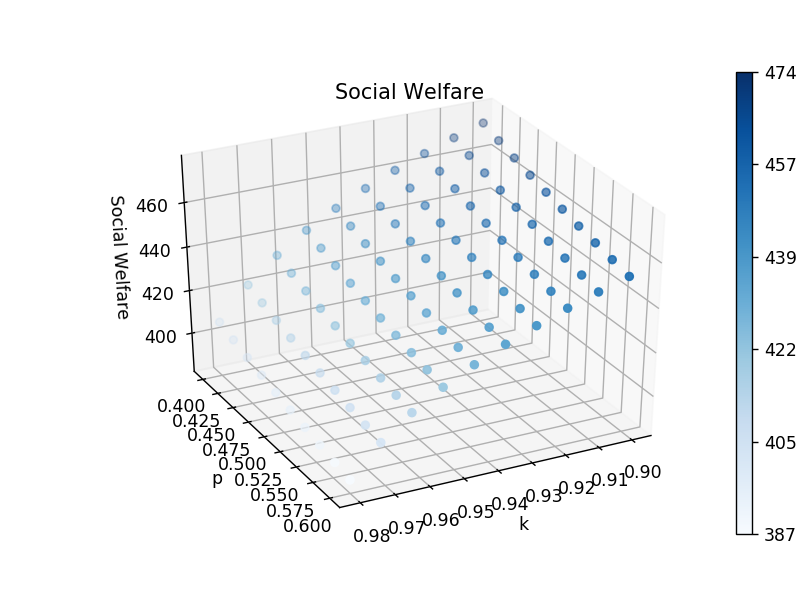

In [12]:
import numpy as np  # 用来处理数据
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.colors 
import matplotlib.ticker
import matplotlib as mpl

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

%matplotlib notebook

fig = plt.figure()
min_v = min(plotSocialWelfare)
max_v = max(plotSocialWelfare)
color = [plt.get_cmap("Blues", 100)(int(float(i-min_v)/(max_v-min_v)*100)) for i in plotSocialWelfare]

 
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
plt.set_cmap(plt.get_cmap("Blues", 100))
ax.set_title('Social Welfare')  # 设置本图名称
im=ax.scatter(kk,pp,plotSocialWelfare,c =color)   # 绘制数据点 c: 'r'红色，'y'黄色，等颜色
ax.view_init(elev=33, azim=63)
# fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)))

ax.set_xlabel('k')  # 设置x坐标轴
ax.set_ylabel('p')  # 设置y坐标轴
ax.set_zlabel('Social Welfare')  # 设置z坐标轴

cax = add_right_cax(ax, pad=0.02, width=0.02)
cbar = fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)),cax=cax)
plt.savefig('SocialWelfare.pdf')
plt.show()

#### Firm Welfare

<IPython.core.display.Javascript object>


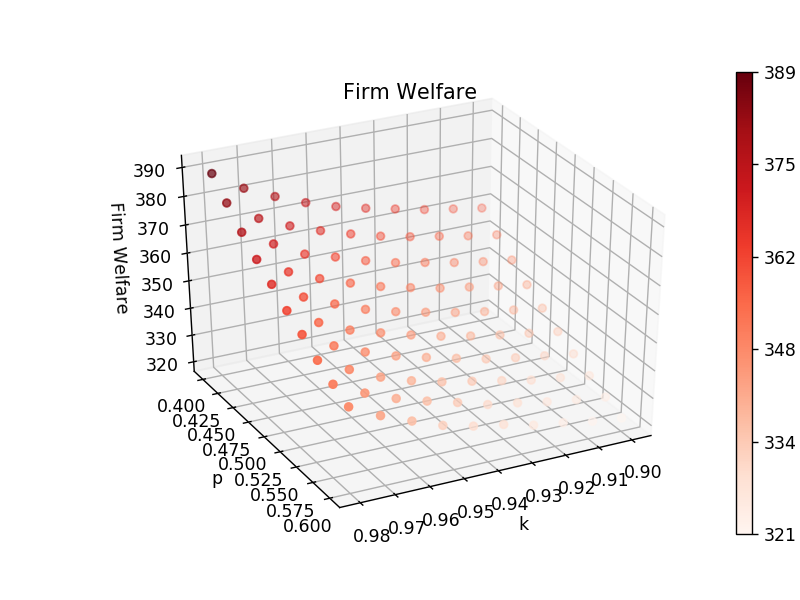

In [13]:
import numpy as np  # 用来处理数据
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from matplotlib import pyplot as plt

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

%matplotlib notebook
 
fig = plt.figure()
min_v = min(plotFirmWelfare)
max_v = max(plotFirmWelfare)
color = [plt.get_cmap("Reds", 100)(int(float(i-min_v)/(max_v-min_v)*100)) for i in plotFirmWelfare]
 
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
plt.set_cmap(plt.get_cmap("Reds", 100))
ax.set_title('Firm Welfare')  # 设置本图名称
im=ax.scatter(kk,pp,plotFirmWelfare, c = color)   # 绘制数据点 c: 'r'红色，'y'黄色，等颜色
ax.view_init(elev=33, azim=63)
# fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)))
cax = add_right_cax(ax, pad=0.02, width=0.02)
cbar = fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)),cax=cax)

ax.set_xlabel('k')  # 设置x坐标轴
ax.set_ylabel('p')  # 设置y坐标轴
ax.set_zlabel('Firm Welfare')  # 设置z坐标轴
plt.savefig('FirmWelfare.pdf')
plt.show()

#### Difference

<IPython.core.display.Javascript object>


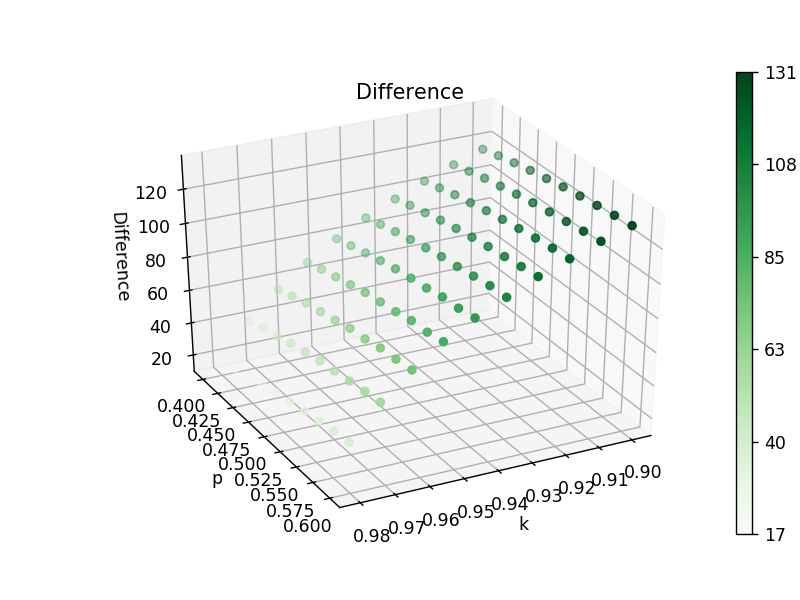

In [9]:
import numpy as np  # 用来处理数据
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.colors 
import matplotlib.ticker
import matplotlib as mpl

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

%matplotlib notebook

fig = plt.figure()
min_v = min(plotDifference)
max_v = max(plotDifference)
color = [plt.get_cmap("Greens", 100)(int(float(i-min_v)/(max_v-min_v)*100)) for i in plotDifference]

 
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
plt.set_cmap(plt.get_cmap("Greens", 100))
ax.set_title('Difference')  # 设置本图名称
im=ax.scatter(kk,pp,plotDifference,c =color)   # 绘制数据点 c: 'r'红色，'y'黄色，等颜色
ax.view_init(elev=33, azim=63)
# fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)))

ax.set_xlabel('k')  # 设置x坐标轴
ax.set_ylabel('p')  # 设置y坐标轴
ax.set_zlabel('Difference')  # 设置z坐标轴

cax = add_right_cax(ax, pad=0.02, width=0.02)
cbar = fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)),cax=cax)
# plt.savefig('SocialWelfare.pdf')
plt.show()

# 画图

代码在matlab中运行的，快。

## 输入参数   BBB在dx中，有不收敛值

In [18]:
import numpy as np

kmin=0.01;
pmin=0.01;
kmax=0.99;
pmax=0.99;
k=np.linspace(kmin,kmax,99)
p=np.linspace(pmin,pmax,99)

In [24]:
Data=np.array(Data)
SW=np.transpose(Data[0:99,1])
# for i in range(2,99,1):
    
# print(SW)
for i in range(1,99,1):
    AAA=np.transpose(Data[0+i*99:99+i*99,1])
    SW=np.vstack([SW,AAA])
    
FW=np.transpose(Data[0:99,0])  
print(FW)
for i in range(1,99,1):
    AAA=np.transpose(Data[0+i*99:99+i*99,0])
    FW=np.vstack([FW,AAA])
# print(SW)       行指的是p，列指的是k

[15.61832355 16.16951165 16.72255573 17.27751375 17.83444602 18.3934155
 18.95448807 19.5177328  20.08322227 20.6510329  21.2212453  21.79394465
 22.3692211  22.94717031 23.52789389 24.11149999 24.69810396 25.28782907
 25.88080728 26.4771802  27.0771001  27.68073107 28.2882504  28.89985015
 29.51573885 30.13614369 30.76131282 31.39151826 32.02705921 32.66826597
 33.31550472 33.9691831  34.62975714 35.29773962 35.97371035 36.65832906
 37.35235153 38.05665012 38.77224037 39.50031564 40.24229343 40.99987811
 41.77514796 42.57067894 43.38972589 44.2364973  45.11658951 46.03770934
 47.0109573  48.05330799 49.19299661 50.4834038  52.05073986 54.41167566
 61.69608028 61.71434907 61.72850969 61.74310282 61.76295258 61.77823016
 61.79396751 61.81022562 61.83228692 61.84939295 61.94047781 61.96598064
 61.98481645 62.00424863 62.02431596 62.04506206 62.07269924 62.09781919
 62.12123887 62.14558452 62.17093186 62.19736629 62.22498609 62.26064492
 62.29628281 62.32878644 62.36308883 62.39939857 62.

In [21]:
print(Data)
# print(FW)

[[  15.61832355 1079.80107178]
 [  16.16951165 1080.37158551]
 [  16.72255573 1080.92480747]
 ...
 [  39.88849016  431.58918041]
 [  41.53850086  390.48430512]
 [  44.51888442  347.18110125]]


## 画图

In [26]:
print(k,p)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99] [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 

<IPython.core.display.Javascript object>


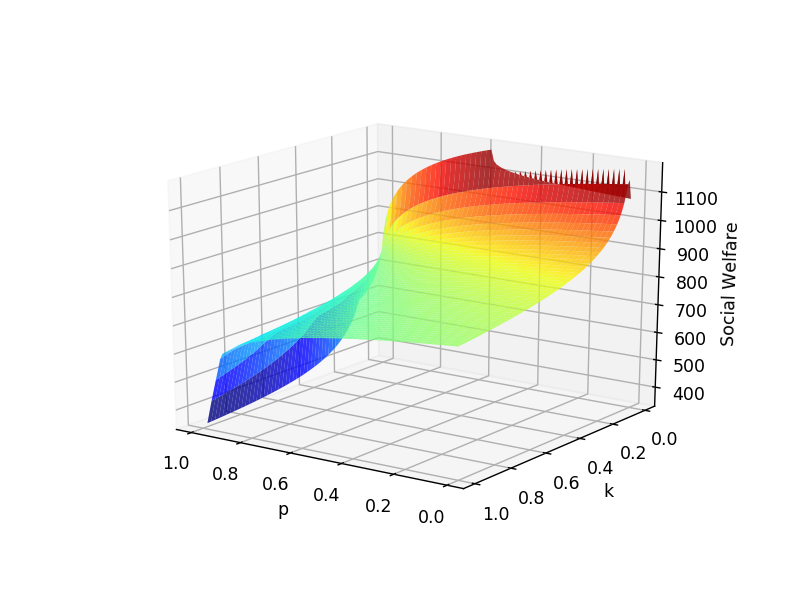

In [27]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

SW=np.transpose(SW)

Xl,Yl = np.meshgrid(p,k)

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=19, azim=125)
ax.plot_surface(Xl,Yl,SW,cmap='jet',alpha=0.8)
ax.set_xlabel('p')
ax.set_ylabel('k')
ax.set_zlabel('Social Welfare')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
# plt.savefig('SW.pdf')
plt.show()

In [26]:
SW=np.transpose(SW)

<IPython.core.display.Javascript object>


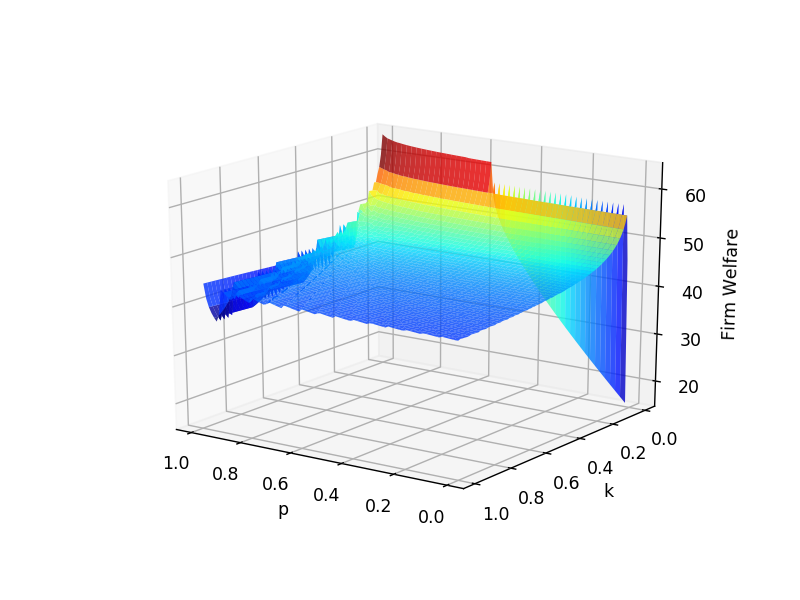

In [54]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

FW=np.transpose(FW)

Xl,Yl = np.meshgrid(p,k)

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=19, azim=125)
ax.plot_surface(Xl,Yl,FW,cmap='jet',alpha=0.8)
ax.set_xlabel('p')
ax.set_ylabel('k')
ax.set_zlabel('Firm Welfare')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
plt.savefig('FW.pdf')
plt.show()

## 输入参数  BBB在效用函数中，没有不收敛的值

In [ ]:
 import numpy as np

kmin=0.01;
pmin=0.01;
kmax=0.99;
pmax=0.99;
k=np.linspace(kmin,kmax,99)
p=np.linspace(pmin,pmax,99)

# 直接调用函数输入excel中的值

## BBB在dx中，有不收敛的值 

In [2]:
import matplotlib.pyplot as plt  #画图用
import numpy as np
import matplotlib
import xlrd 

# file_location="C:/Users/DELL/Desktop/福利.xlsx"
file_location="福利.xlsx"
data = xlrd.open_workbook(file_location)

sheet=data.sheet_by_index(5)  #0就是第一张表
fw=[sheet.cell_value(r,3) for r in range(0,sheet.nrows)]
sw=[sheet.cell_value(r,4) for r in range(0,sheet.nrows)]
# print(type(fw))
fw=np.array(fw)
sw=np.array(sw)
print(fw.shape)
# fw=np.transpose(fw)
# sw=np.transpose(sw)
Data=np.vstack([fw,sw])
Data=np.transpose(Data)
print(type(Data),Data.shape)

(9801,)
<class 'numpy.ndarray'> (9801, 2)


In [3]:
kmin=0.01;
pmin=0.01;
kmax=0.99;
pmax=0.99;
# x = np.arange(-3.0, 3.0, delta)
# # 生成代表Y轴数据的列表
# y = np.arange(-2.0, 2.0, delta)
k=np.linspace(kmin,kmax,99)
p=np.linspace(pmin,pmax,99)

# k=np.linspace(kmax,kmin,99)
# p=np.linspace(pmax,pmin,99)

SW=np.transpose(Data[0:99,1])

for i in range(1,99,1):
    AAA=np.transpose(Data[0+i*99:99+i*99,1])
    SW=np.vstack([SW,AAA])
    
FW=np.transpose(Data[0:99,0])  

for i in range(1,99,1):
    AAA=np.transpose(Data[0+i*99:99+i*99,0])
    FW=np.vstack([FW,AAA])
# print(SW)       行指的是p，列指的是k

In [4]:
# print(SW)
SW=np.transpose(SW)
# print(SW)

In [9]:
print(np.linspace(5,1,4))

[5.         3.66666667 2.33333333 1.        ]


## 画图 

<IPython.core.display.Javascript object>


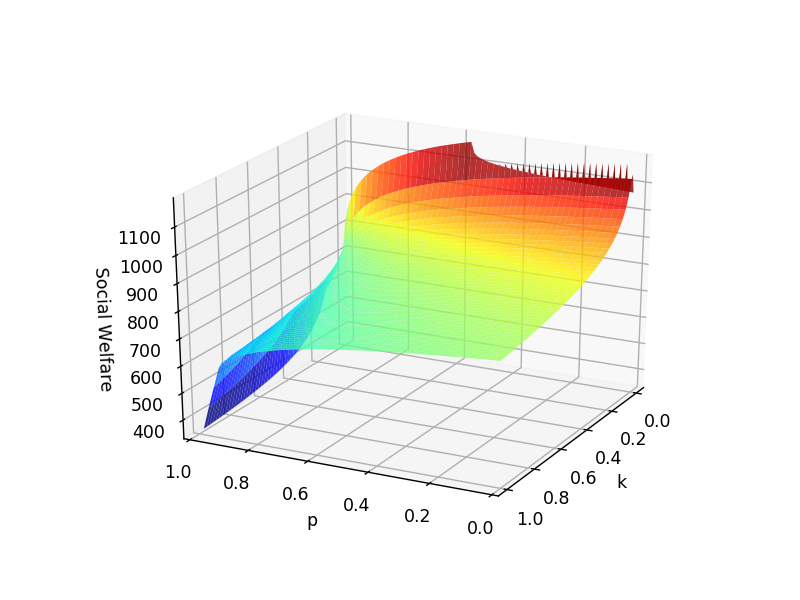

In [5]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

# SW=np.transpose(SW)

X1 ,Y1= np.meshgrid(k,p)
# Y1=np.transpose(Y1)
# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=24, azim=-58)
ax.plot_surface(X1,Y1,SW,cmap='jet',alpha=0.8)
ax.set_xlabel('k')
ax.set_ylabel('p')
ax.set_zlabel('Social Welfare')
ax.set_ylim(1.0,0)
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
plt.savefig('SW6.13.pdf')
plt.show()

In [70]:
print(X1)
print(Y1)
Y1=np.transpose(Y1)
print(Y1)
# print(SW)
# fig = plt.figure(figsize=(12, 8))
# ax = Axes3D(fig)
# '''
# fig = plt.figure(figsize=(12, 8))
# ax = fig.gca(projection='3d')
# '''

# delta = 0.125
# # 生成代表X轴数据的列表
# x = np.arange(-3.0, 3.0, delta)
# # 生成代表Y轴数据的列表
# y = np.arange(-2.0, 2.0, delta)
# # 对x、y数据执行网格化
# X, Y = np.meshgrid(x, y)
# Z1 = np.exp(-X**2 - Y**2)
# Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
# # 计算Z轴数据（高度数据）
# Z = (Z1 - Z2) * 2
# # 绘制3D图形
# surf = ax.plot_surface(X, Y, Z,
#                        rstride=1,  # rstride（row）指定行的跨度
#                        cstride=1,  # cstride(column)指定列的跨度
#                        cmap=plt.get_cmap('rainbow'))  # 设置颜色映射
# # 设置Z轴范围
# ax.set_zlim(-2, 2)
# # 设置标题
# plt.title("3D图")
# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.show()

[[0.01 0.02 0.03 ... 0.97 0.98 0.99]
 [0.01 0.02 0.03 ... 0.97 0.98 0.99]
 [0.01 0.02 0.03 ... 0.97 0.98 0.99]
 ...
 [0.01 0.02 0.03 ... 0.97 0.98 0.99]
 [0.01 0.02 0.03 ... 0.97 0.98 0.99]
 [0.01 0.02 0.03 ... 0.97 0.98 0.99]]
[[0.01 0.02 0.03 ... 0.97 0.98 0.99]
 [0.01 0.02 0.03 ... 0.97 0.98 0.99]
 [0.01 0.02 0.03 ... 0.97 0.98 0.99]
 ...
 [0.01 0.02 0.03 ... 0.97 0.98 0.99]
 [0.01 0.02 0.03 ... 0.97 0.98 0.99]
 [0.01 0.02 0.03 ... 0.97 0.98 0.99]]
[[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]
 ...
 [0.97 0.97 0.97 ... 0.97 0.97 0.97]
 [0.98 0.98 0.98 ... 0.98 0.98 0.98]
 [0.99 0.99 0.99 ... 0.99 0.99 0.99]]


In [72]:
? ax.plot_surface


<IPython.core.display.Javascript object>


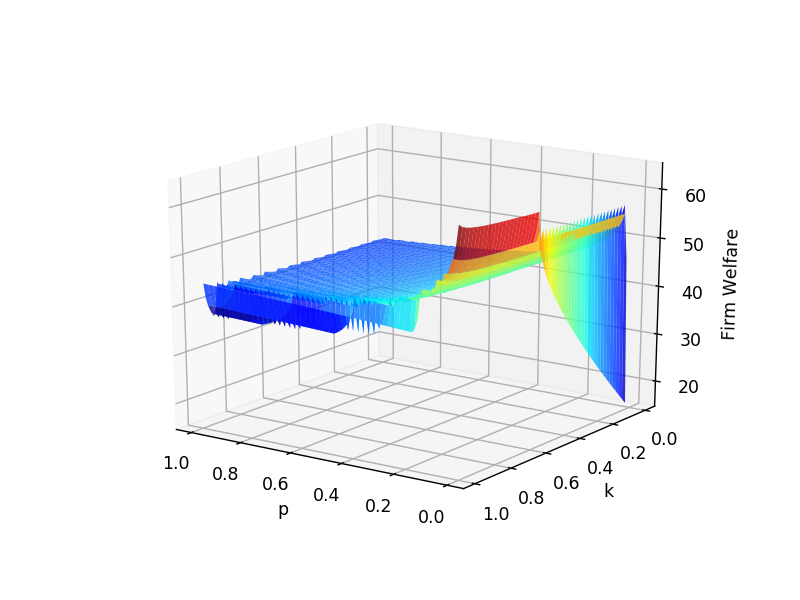

In [17]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

FW=np.transpose(FW)

Xl,Yl = np.meshgrid(p,k)

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=19, azim=125)
ax.plot_surface(Xl,Yl,FW,cmap='jet',alpha=0.8)
ax.set_xlabel('p')
ax.set_ylabel('k')
ax.set_zlabel('Firm Welfare')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
# plt.savefig('FW.pdf')
plt.show()

## BBB在效用函数中，有不收敛的值

In [13]:
import matplotlib.pyplot as plt  #画图用
import numpy as np
import matplotlib
import xlrd 

file_location="C:/Users/DELL/Desktop/福利.xlsx"
data = xlrd.open_workbook(file_location)

sheet=data.sheet_by_index(6)
fw1=[sheet.cell_value(r,3) for r in range(0,sheet.nrows)]
sw1=[sheet.cell_value(r,4) for r in range(0,sheet.nrows)]
# print(type(fw))

fw=[np.nan if i=='NaN' else i for i in fw1]
sw=[np.nan if i=='NaN' else i for i in sw1]

fw=np.array(fw)
sw=np.array(sw)
print(fw.shape)
# fw=np.transpose(fw)
# sw=np.transpose(sw)
Data=np.vstack([fw,sw])
Data=np.transpose(Data)
print(type(Data),Data.shape)

(9801,)
<class 'numpy.ndarray'> (9801, 2)


In [14]:
kmin=0.01;
pmin=0.01;
kmax=0.99;
pmax=0.99;
k=np.linspace(kmin,kmax,99)
p=np.linspace(pmin,pmax,99)

Data=np.array(Data)
SW=np.transpose(Data[0:99,1])

for i in range(1,99,1):
    AAA=np.transpose(Data[0+i*99:99+i*99,1])
    SW=np.vstack([SW,AAA])
    
FW=np.transpose(Data[0:99,0])  

for i in range(1,99,1):
    AAA=np.transpose(Data[0+i*99:99+i*99,0])
    FW=np.vstack([FW,AAA])
# print(SW)       行指的是p，列指的是k

## 画图

In [15]:
SW=np.array(SW)
print(type(SW))
SW[SW=='NaN']=0
T=[0,'R',1]
print(T)
T[T=='R']=20
print(T)

<class 'numpy.ndarray'>
[0, 'R', 1]
[20, 'R', 1]


E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


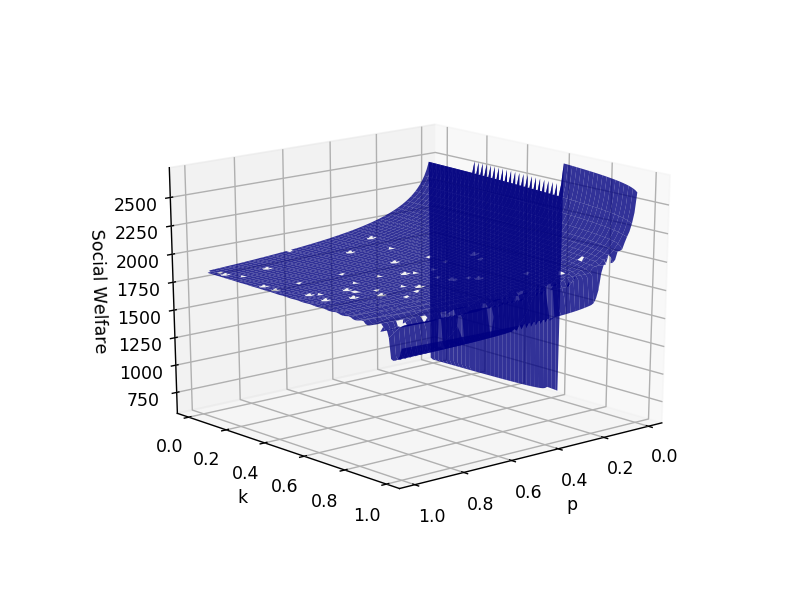

E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Z contains NaN values. This may result in rendering artifacts.


In [16]:
# where_are_nan = np.isnan(SW)
# where_are_inf = np.isinf(Vchangecopy)
# SW[where_are_nan] = 0
# Vchangecopy[where_are_inf] = 0

# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

SW=np.transpose(SW)

Xl,Yl = np.meshgrid(p,k)

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=19, azim=125)
ax.plot_surface(Xl,Yl,SW,cmap='jet',alpha=0.8)
ax.set_xlabel('p')
ax.set_ylabel('k')
ax.set_zlabel('Social Welfare')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
# plt.savefig('SW.pdf')
plt.show()

<IPython.core.display.Javascript object>


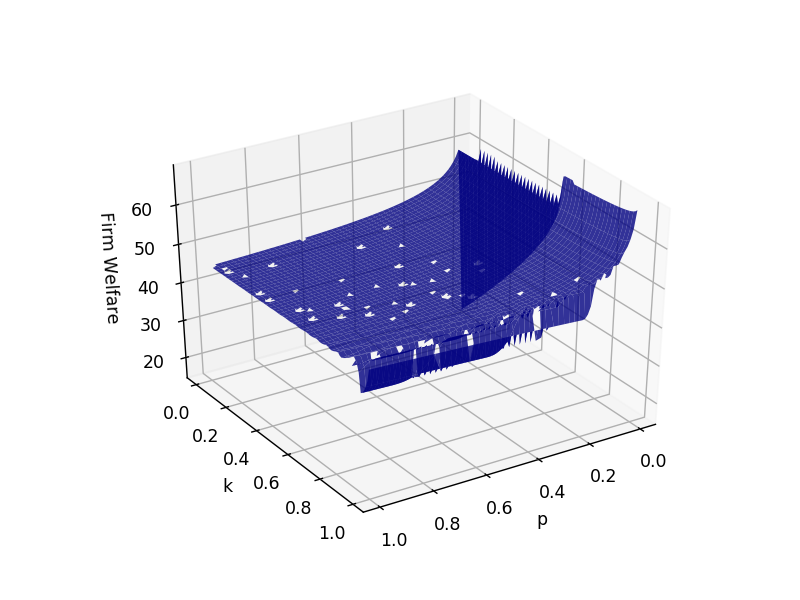

E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.


In [17]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

FW=np.transpose(FW)

Xl,Yl = np.meshgrid(p,k)

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=19, azim=125)
ax.plot_surface(Xl,Yl,FW,cmap='jet',alpha=0.8)
ax.set_xlabel('p')
ax.set_ylabel('k')
ax.set_zlabel('Firm Welfare')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
# plt.savefig('FW.pdf')
plt.show()

## BBB在dx里，没有不收敛的值

In [1]:
import matplotlib.pyplot as plt  #画图用
import numpy as np
import matplotlib
import xlrd 

file_location="C:/Users/DELL/Desktop/福利.xlsx"
data = xlrd.open_workbook(file_location)

sheet=data.sheet_by_index(8)
fw1=[sheet.cell_value(r,3) for r in range(0,sheet.nrows)]
sw1=[sheet.cell_value(r,4) for r in range(0,sheet.nrows)]
# print(type(fw))

fw=[np.nan if i=='NaN' else i for i in fw1]
sw=[np.nan if i=='NaN' else i for i in sw1]

fw=np.array(fw)
sw=np.array(sw)
print(fw.shape)
# fw=np.transpose(fw)
# sw=np.transpose(sw)
Data=np.vstack([fw,sw])
Data=np.transpose(Data)
print(type(Data),Data.shape)

(9801,)
<class 'numpy.ndarray'> (9801, 2)


In [2]:
kmin=0.01;
pmin=0.01;
kmax=0.99;
pmax=0.99;
k=np.linspace(kmin,kmax,99)
p=np.linspace(pmin,pmax,99)

SW=np.transpose(Data[0:99,1])

for i in range(1,99,1):
    AAA=np.transpose(Data[0+i*99:99+i*99,1])
    SW=np.vstack([SW,AAA])
    
FW=np.transpose(Data[0:99,0])  

for i in range(1,99,1):
    AAA=np.transpose(Data[0+i*99:99+i*99,0])
    FW=np.vstack([FW,AAA])
# print(SW)       行指的是p，列指的是k

## 画图 

<IPython.core.display.Javascript object>


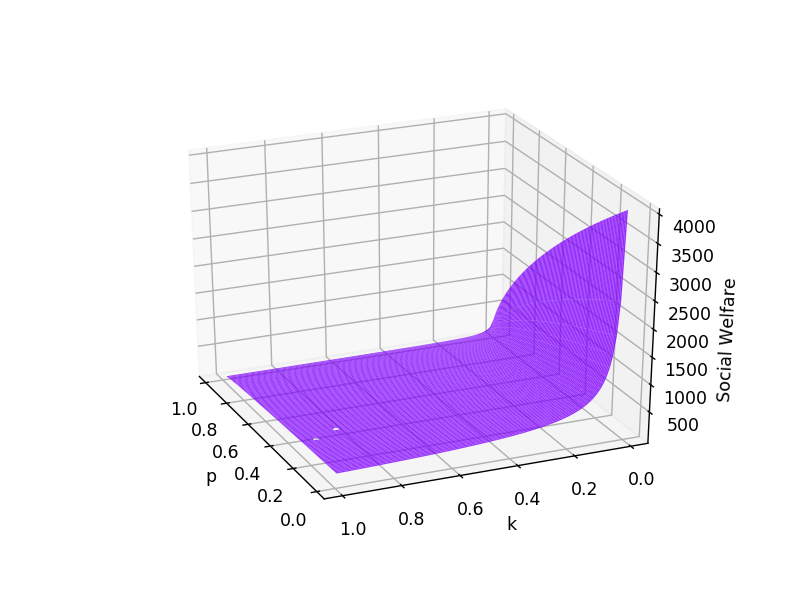

E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.


In [9]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

SW=np.transpose(SW)

Xl,Yl = np.meshgrid(p,k)

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=19, azim=125)
ax.plot_surface(Xl,Yl,SW,rstride=1, cstride=1, cmap='rainbow',alpha=0.8)
ax.set_xlabel('p')
ax.set_ylabel('k')
ax.set_zlabel('Social Welfare')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
# plt.savefig('SW.pdf')
plt.show()

<IPython.core.display.Javascript object>


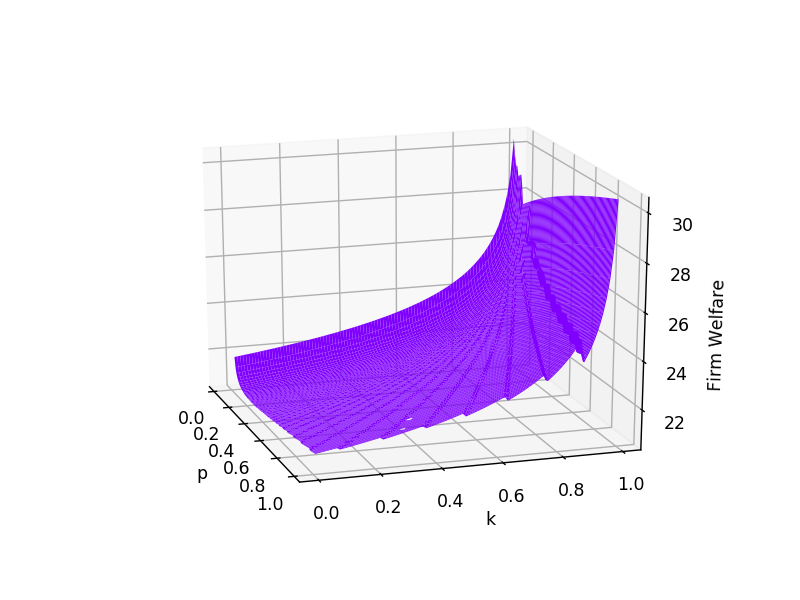

E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Z contains NaN values. This may result in rendering artifacts.


In [8]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

FW=np.transpose(FW)

Xl,Yl = np.meshgrid(p,k)

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
# ax=Axes3D(fig)
ax.view_init(elev=19, azim=125)
ax.plot_surface(Xl,Yl,FW,rstride=1, cstride=1, cmap='rainbow')
# ax.plot_surface(X, Y, Z, )cmap='jet',alpha=0.8
ax.set_xlabel('p')
ax.set_ylabel('k')
ax.set_zlabel('Firm Welfare')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
# plt.savefig('FW.pdf')
plt.show()

## BBB在效用函数里，没有不收敛的值

In [1]:
import matplotlib.pyplot as plt  #画图用
import numpy as np
import matplotlib
import xlrd 

file_location="C:/Users/DELL/Desktop/福利.xlsx"
data = xlrd.open_workbook(file_location)

sheet=data.sheet_by_index(7)
fw1=[sheet.cell_value(r,3) for r in range(0,sheet.nrows)]
sw1=[sheet.cell_value(r,4) for r in range(0,sheet.nrows)]
# print(type(fw))

fw=[np.nan if i=='NaN' else i for i in fw1]
sw=[np.nan if i=='NaN' else i for i in sw1]

fw=np.array(fw)
sw=np.array(sw)
print(fw.shape)
# fw=np.transpose(fw)
# sw=np.transpose(sw)
Data=np.vstack([fw,sw])
Data=np.transpose(Data)
print(type(Data),Data.shape)

(9801,)
<class 'numpy.ndarray'> (9801, 2)


In [2]:
kmin=0.01;
pmin=0.01;
kmax=0.99;
pmax=0.99;
k=np.linspace(kmin,kmax,99)
p=np.linspace(pmin,pmax,99)

SW=np.transpose(Data[0:99,1])

for i in range(1,99,1):
    AAA=np.transpose(Data[0+i*99:99+i*99,1])
    SW=np.vstack([SW,AAA])
    
FW=np.transpose(Data[0:99,0])  

for i in range(1,99,1):
    AAA=np.transpose(Data[0+i*99:99+i*99,0])
    FW=np.vstack([FW,AAA])
# print(SW)       行指的是p，列指的是k

## 画图 

<IPython.core.display.Javascript object>


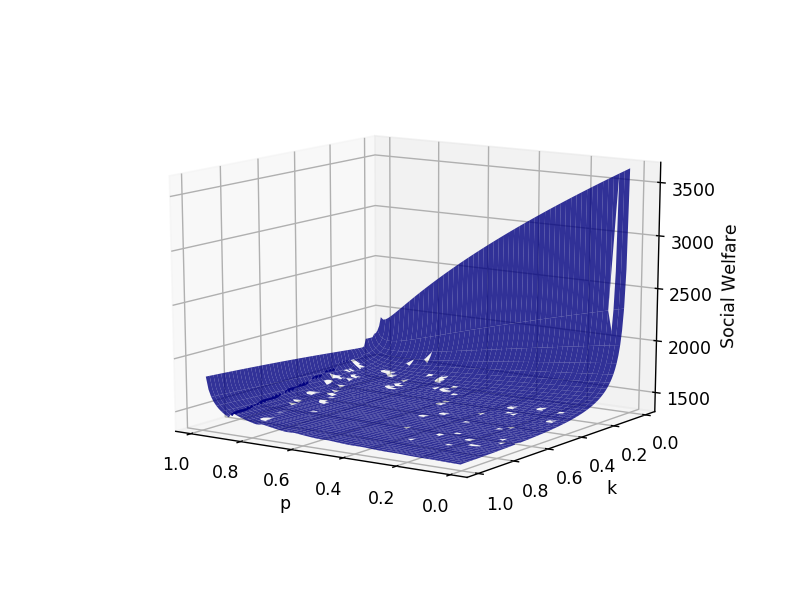

E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.


In [5]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

SW=np.transpose(SW)

Xl,Yl = np.meshgrid(p,k)

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=19, azim=125)
ax.plot_surface(Xl,Yl,SW,cmap='jet',alpha=0.8)
ax.set_xlabel('p')
ax.set_ylabel('k')
ax.set_zlabel('Social Welfare')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
# plt.savefig('SW.pdf')
plt.show()

<IPython.core.display.Javascript object>


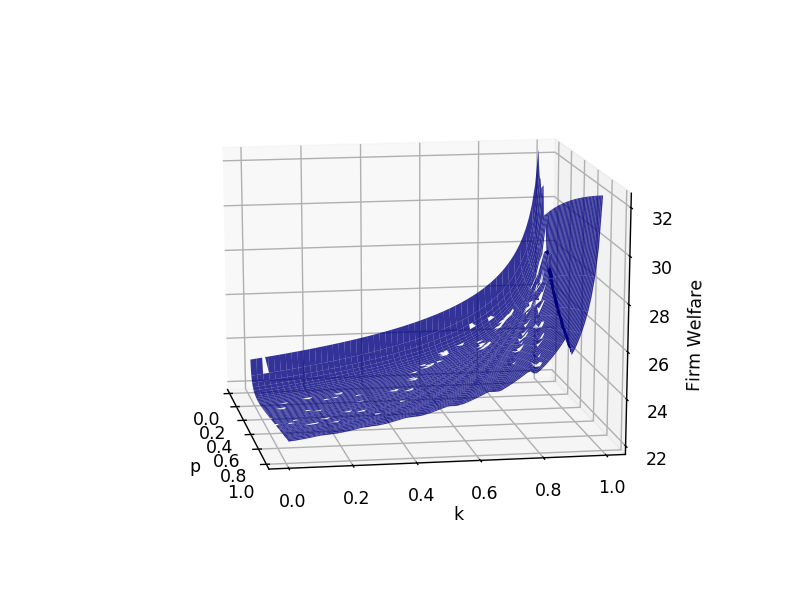

E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.


In [4]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

FW=np.transpose(FW)

Xl,Yl = np.meshgrid(p,k)

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=19, azim=125)
ax.plot_surface(Xl,Yl,FW,cmap='jet',alpha=0.8)
ax.set_xlabel('p')
ax.set_ylabel('k')
ax.set_zlabel('Firm Welfare')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
# plt.savefig('FW.pdf')
plt.show()

# 我应该想办法调整一下参数使得效用函数的后半段符合最最开始的假设